In [102]:
beam_angle = 15 #sensor beam field of view (FoV). In degrees
beam_max_range = 2 #max range allowed for the beam. In meters
sensors = 3 #number of transmiters/receivers
propagation_speed = 340 #wave propagation speeed over air. In m/s
initial_amplitude = 1 #initial amplitude of the wave
wave_frequency = 40e3 #Wave frequency, in Hertz
sampling_rate = 1/6800 #Sampling rate in seconds

main_sensor_coordinates = [0,0] #Origin Coordinates of the main sensor [X,Y}

Calculate the origin coordinates for the other sensors..

Supposing 2 more sensors, one located on the right of the main sensor and the other on the left of the main sensor.

The sensor on the left (S1) needs to be located such that the upper-right part of the beam locates the exact same position as the main sensor upper-right extreme.
The upper-left extreme of the S1 Beam can be located over the main beam, by a percentage of the main beam range. Lets say, 10%.

The same logic applies to the sensor on the right (S3) but mirrored.

### Library import

In [125]:
import shapely
from itertools import product
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

plt.rcParams["figure.figsize"] = (6,6)

In [3]:
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import LineString
from shapely import affinity

### Auxiliary functions

In [4]:
#function that creates a equaly space grid for a given geometry
def make_grid(polygon, edge_size):
    """
    polygon : shapely.geometry
    edge_size : length of the grid cell
    """
    bounds = polygon.bounds
    x_coords = np.arange(bounds[0] + edge_size/2, bounds[2], edge_size)
    y_coords = np.arange(bounds[1] + edge_size/2, bounds[3], edge_size)
    combinations = np.array(list(product(x_coords, y_coords)))
    squares = gpd.points_from_xy(combinations[:, 0], combinations[:, 1]).buffer(edge_size / 2, cap_style=3)

    return gpd.GeoSeries(squares[squares.intersects(polygon)])

In [5]:
def check_is_inside(geometry, points):
    """
    arguments:  - geometry: geometry to check
                - point to check if is inside of the geometry
    
    output: - Quadrant number in wich the point is inside (if any)
            - Coordinates of the respective quadrant
    """
    index = 0
    quadrant_index = []
    points_inside = []
    for quadrant in geometry:
        for point in points:
            is_inside = quadrant.contains(point)
            if is_inside == True:
                coords = np.dstack(quadrant.boundary.coords.xy).tolist()
                quadrant_index.append(index)
                points_inside.append(point)
                print('The point is inside of the #', index, 'quadrant. With coordinates: ', coords, '\n')
            
        index += 1
        
    if len(points) != len(quadrant_index):
        print('One of the point/s is outside of the detectection area!\n')
        
    print('\nAmount of scanned quadrants:', index)
    if len(quadrant_index) == 0:
        quadrant_index = False
        coords = False
        print('The point is not inside of the geometry!')
    return quadrant_index, coords, points_inside

In [395]:
def get_propagation_data(objects_inside):
    #origin coordinates for each sensor
    sensors_coordinates = [sensor_1_coordinates, sensor_2_coordinates, sensor_3_coordinates]

    output_data = np.zeros([1,3,81])
    
    traced_objects_coordinates = []

    #for each sensor
    for sensor in range(sensors):
        #get the origin point
        origin_coord = sensors_coordinates[sensor]

        #for every object
        for object_to_trace in objects_inside:
            #get the centroid of the object
            object_to_trace_coordinates = np.dstack(grid_geometry[object_to_trace].centroid.coords.xy).tolist()[0][0]
            #get the rount trip distance from the sensor origin to the object
            round_trip_distance = 2 * math.dist(object_to_trace_coordinates, origin_coord)
            #get the rount trip time
            round_trip_time = round_trip_distance / propagation_speed
            #get the final wave amplitude
            wave_amplitude = initial_amplitude * np.exp((-2e-13)*propagation_speed*(wave_frequency**2)*round_trip_time) 

            #quantize the travel time
            quantized_time = round_trip_time / sampling_rate
            #Fill the output data matrix with the calculated values
            #Note: The value will be 1 until the wave propagation analysis is solved.
            output_data[0][sensor][int(np.round(quantized_time) - 1)] = 1
            
            if sensor == 0:
                traced_objects_coordinates.append(object_to_trace_coordinates)
            
        
        #print(np.round(quantized_time))
        
    return traced_objects_coordinates, output_data

### Geometries calculation

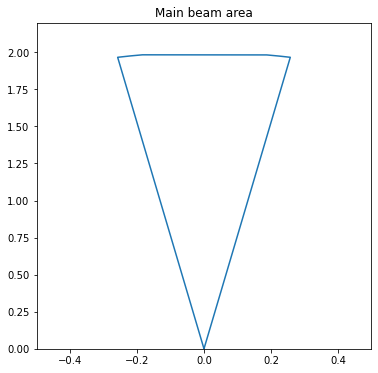

In [41]:
#Geometry of the main beam (sensor 2)
#create a triangle with coordinates points
p1 = Point(0,0)
p2 = Point(0.26, 1.983)
p3 = Point(-0.26, 1.983)

triangle1 = Polygon([p1, p2,p3])

#create a circle
diameter = 1
circle1 = Point(0, 1).buffer(diameter, resolution= 50000)

#intersect both geometries
geometry_1 = triangle1.intersection(circle1)

#calculate the origin coordinates for the beam sensor
sensor_2_coordinates = np.dstack(p1.coords.xy).tolist()[0][0]

x, y = geometry_1.exterior.xy
plt.plot(x, y)
plt.xlim([-0.5,0.5])
plt.ylim([0, 2.2])
plt.title('Main beam area')
plt.show()

In [42]:
#Geometry of the secondary left beam (sensor 1)

#rotate by the main beam by the upper-right point
rotate_point = (-0.26, 1.983)
rotation_angle = -5
geometry_2 = affinity.rotate(geometry_1,
                             rotation_angle,
                             rotate_point)
#calculate the origin coordinates for the beam sensor
sensor_1_coordinates = np.dstack(affinity.rotate(triangle1,
                                 rotation_angle,
                                 rotate_point).exterior.coords.xy).tolist()[0][0]

In [43]:
#Geometry of the third right beam (sensor 3)

#rotate by the main beam by the upper-right point
rotate_point = (0.26, 1.983)
rotation_angle = +5
geometry_3 = affinity.rotate(geometry_1,
                             rotation_angle,
                             rotate_point)
#calculate the origin coordinates for the beam sensor
sensor_3_coordinates = np.dstack(affinity.rotate(triangle1,
                                 rotation_angle,
                                 rotate_point).exterior.coords.xy).tolist()[0][0]

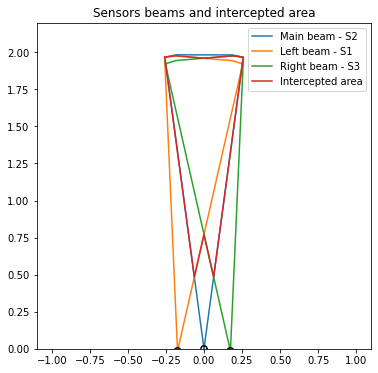

In [44]:
#Unify all the geometries
int_1 = geometry_1.intersection(geometry_2)
int_2 = geometry_1.intersection(geometry_3)
int_3 = int_1.union(int_2)

#plot main beam geometry
x, y = geometry_1.exterior.xy
plt.plot(x, y, label = 'Main beam - S2')
#plot secondary left beam geometry
x, y = geometry_2.exterior.xy
plt.plot(x, y, label = 'Left beam - S1')
#plot secondary right beam geometry
x, y = geometry_3.exterior.xy
plt.plot(x, y, label = 'Right beam - S3')
#plot interception of the 3 beams and resulting effective detection area
x, y = int_3.exterior.xy
plt.plot(x, y, label = 'Intercepted area')

#plot the sensor 1 origin
x,y = Point(sensor_1_coordinates[0],
            sensor_1_coordinates[1]).buffer(0.022).exterior.xy
plt.plot(x,y, color = 'black')
#plot the sensor 2 origin
x,y = p1.buffer(0.02).exterior.xy
plt.plot(x,y, color = 'black')
#plot the sensor 3 origin
x,y = Point(sensor_3_coordinates[0],
            sensor_3_coordinates[1]).buffer(0.022).exterior.xy
plt.plot(x,y, color = 'black')

plt.legend()
plt.xlim([-1.1, 1.1])
plt.ylim([0, 2.2])
plt.title('Sensors beams and intercepted area')
plt.show()

The point is inside of the # 0 quadrant. With coordinates:  [[[-0.19779715385655994, 1.5639593874382902], [-0.19779715385655994, 1.5039593874382902], [-0.25779715385655994, 1.5039593874382902], [-0.25779715385655994, 1.5639593874382902], [-0.19779715385655994, 1.5639593874382902]]] 

The point is inside of the # 93 quadrant. With coordinates:  [[[0.042202846143440054, 1.80395938743829], [0.042202846143440054, 1.74395938743829], [-0.017797153856559944, 1.74395938743829], [-0.017797153856559944, 1.80395938743829], [0.042202846143440054, 1.80395938743829]]] 

The point is inside of the # 134 quadrant. With coordinates:  [[[0.16220284614344005, 1.5039593874382902], [0.16220284614344005, 1.44395938743829], [0.10220284614344005, 1.44395938743829], [0.10220284614344005, 1.5039593874382902], [0.16220284614344005, 1.5039593874382902]]] 


Amount of scanned quadrants: 161




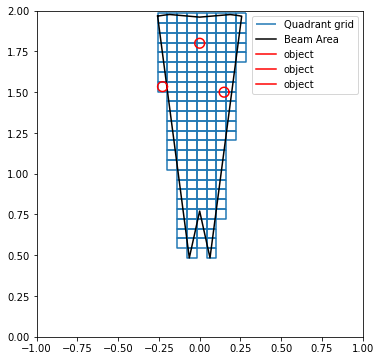

In [146]:
#divide the final geometry into equally size quadrants
quadrant_size = 0.06
grid_geometry = make_grid(int_3,
                          quadrant_size)

#place an object and identify in which quadrant it is located
objects_coordinates = [Point(-0.22779715385655996, 1.5339593874382902),
                       Point(.15, 1.5),
                      Point(0, 1.8)]

#If any, calculate the quadrants in wich the objects are placed
affected_quadrant = check_is_inside(grid_geometry, objects_coordinates)

print('\n')

#plot the grid 
grid_geometry.boundary.plot(label = 'Quadrant grid')

#plot the composed beam area
x, y = int_3.exterior.xy
plt.plot(x, y, label = 'Beam Area', color= 'black')

#plot the objects
for object_coordinates in affected_quadrant[2]:
    x,y = object_coordinates.buffer(0.03).exterior.xy
    plt.plot(x,y, color = 'red', label = 'object')
    
plt.xlim([-1,1])
plt.ylim([0, 2])
plt.legend()
plt.show()


### Ray-tracing

We need to generate randomly placed Points inside of the quadrant area (grid).
Taking into account the max number of objects, startin with only 1 object, move it around the detection area and save that data.
Then add another object and repeat the taks, but now the available possibilities are much bigger, so we can limitate the number of data to create by condition:
one of the conditions will be the minimum distance between objects, or the number of iterations.
Repeat the procedure for all the allowed objects.

Is important to create the label for the model, in this case will be the quadrant number associated to the scanned objects.

In [388]:
quadrant_number = 161
max_object_number = 3

placed_objects = []
traced_data = np.zeros([quadrant_number, 3, 81])
label_quadrant = []

for object_to_place in range(max_object_number+1):
    #Combinations for 1 object
    if object_to_place == 1:
        #will be the total number of possible quadrants
        for i in range(quadrant_number):
            #calculate the propagation characteristics
            a = get_propagation_data([i])
            
            #placed objects coords - for later printing - 
            placed_objects.append(a[0][0])
            #Add the calculated data
            traced_data[i] = a[1]
            
            #add the quadrant to the label vector
            label_quadrant.append([i])
            
    #Combinations for 2 objects        
    if object_to_place == 2:
        #create fixed number of combinations - by factor - 
        for i in range(5*quadrant_number):
            #create 2 random numbers within the allowed quadrant number
            rand_position_1 = np.random.randint(quadrant_number)
            rand_position_2 = np.random.randint(quadrant_number)
            #in case the rand numbers are equal, re-run one of the random numbers
            if rand_position_1 == rand_position_2:
                rand_position_2 = np.random.randint(quadrant_number)
                
            #calculate the propagation characteristics for each object
            a = get_propagation_data([rand_position_1,
                                      rand_position_2])
            #Add the calculated data
            traced_data = np.append(traced_data, np.array(a[1]), axis = 0)
            
            #add the quadrant to the label vector
            label_quadrant.append([rand_position_1, rand_position_2])
            
    #Combinations for 3 objects        
    if object_to_place == 3:
        #create fixed number of combinations - by factor - 
        for i in range(5*quadrant_number):
            #create 2 random numbers within the allowed quadrant number
            rand_position_1 = np.random.randint(quadrant_number)
            rand_position_2 = np.random.randint(quadrant_number)
            rand_position_3 = np.random.randint(quadrant_number)
            #in case the rand numbers are equal, re-run one of the random numbers
            if rand_position_1 == rand_position_2:
                rand_position_2 = np.random.randint(quadrant_number)
            if rand_position_1 == rand_position_3:
                rand_position_3 = np.random.randint(quadrant_number)
            if rand_position_2 == rand_position_3:
                rand_position_3 = np.random.randint(quadrant_number)
                
            #calculate the propagation characteristics for each object
            a = get_propagation_data([rand_position_1,
                                      rand_position_2,
                                      rand_position_3])
            #Add the calculated data
            traced_data = np.append(traced_data, np.array(a[1]), axis = 0)
            
            #add the quadrant to the label vector
            label_quadrant.append([rand_position_1, rand_position_2, rand_position_3])

<AxesSubplot:>

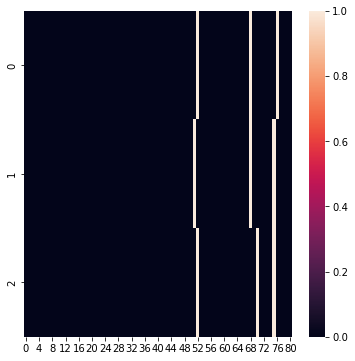

In [394]:
sns.heatmap(traced_data[1159])

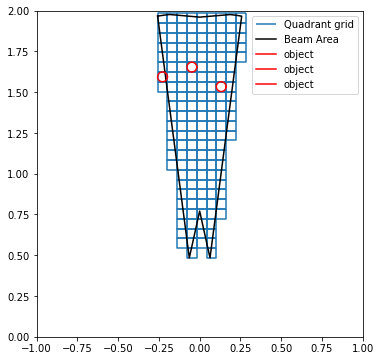

In [400]:
rand_obj = label_quadrant[1190]

#plot the grid 
grid_geometry.boundary.plot(label = 'Quadrant grid')

#plot the composed beam area
x, y = int_3.exterior.xy
plt.plot(x, y, label = 'Beam Area', color= 'black')

#plot the objects
for object_coordinates in rand_obj:
    coords = np.dstack(grid_geometry[object_coordinates].centroid.coords.xy).tolist()[0][0]
    temp_obj = Point(coords)
    x,y = temp_obj.buffer(0.03).exterior.xy
    plt.plot(x,y, color = 'red', label = 'object')
    
plt.xlim([-1,1])
plt.ylim([0, 2])
plt.legend()
plt.show()

Print the placed objects

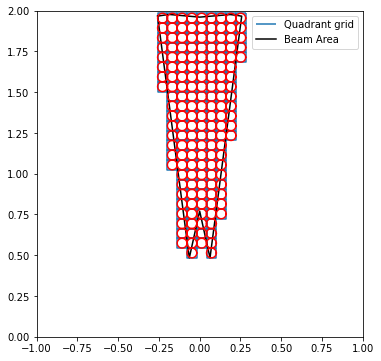

In [309]:
#plot the grid 
grid_geometry.boundary.plot(label = 'Quadrant grid')

#plot the composed beam area
x, y = int_3.exterior.xy
plt.plot(x, y, label = 'Beam Area', color= 'black')

#plot the objects
for object_coordinates in placed_objects:
    temp_obj = Point(object_coordinates)
    x,y = temp_obj.buffer(0.03).exterior.xy
    plt.plot(x,y, color = 'red')
    
plt.xlim([-1,1])
plt.ylim([0, 2])
plt.legend()
plt.show()

### Wave attenuation analysis

In [112]:
20*np.log10(1/wave_amplitude) 

0.008280948719965408

62.0
-0.008616481014265029
72.0
-0.009999023553960915
61.0
-0.008450713678926077
62.0
-0.008620746290715546
71.0
-0.009861619207846471
59.0
-0.008226587030138642
64.0
-0.008895959233893998
72.0
-0.009985904428391704
60.0
-0.008280948719965726




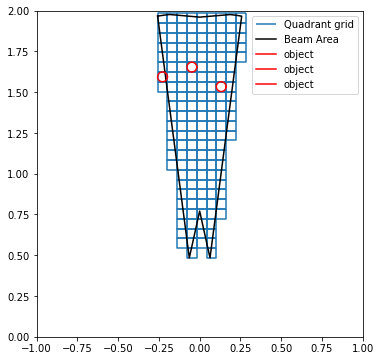

AxesSubplot(0.125,0.125;0.62x0.755)


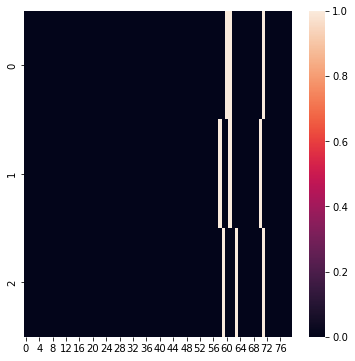

In [409]:
##objects placed into the beam area
objects_inside = [0, 93, 134]
sensors_coordinates = [sensor_1_coordinates, sensor_2_coordinates, sensor_3_coordinates]

output_data = np.zeros([3,80])
    
#for each sensor
for sensor in range(sensors):
    #get the origin point
    origin_coord = sensors_coordinates[sensor]
    
    #for every object
    for object_to_trace in objects_inside:
        #get the centroid of the object
        object_to_trace_coordinates = np.dstack(grid_geometry[object_to_trace].centroid.coords.xy).tolist()[0][0]
        #get the rount trip distance from the sensor origin to the object
        round_trip_distance = 2 * math.dist(object_to_trace_coordinates, origin_coord)
        #get the rount trip time
        round_trip_time = round_trip_distance / propagation_speed
        #get the final wave amplitude
        wave_amplitude = initial_amplitude * np.exp((-2e-13)*propagation_speed*(wave_frequency**2)*round_trip_time) 
        
        #quantize the travel time
        quantized_time = round_trip_time / sampling_rate
        #Fill the output data matrix with the calculated values
        #Note: The value will be 1 until the wave propagation analysis is solved.
        output_data[sensor][int(np.round(quantized_time) - 1)] = 1
        
        print(np.round(quantized_time))
        print(20*np.log10(wave_amplitude/1))
 
print('\n')
rand_obj = label_quadrant[1190]

#plot the grid 
grid_geometry.boundary.plot(label = 'Quadrant grid')

#plot the composed beam area
x, y = int_3.exterior.xy
plt.plot(x, y, label = 'Beam Area', color= 'black')

#plot the objects
for object_coordinates in rand_obj:
    coords = np.dstack(grid_geometry[object_coordinates].centroid.coords.xy).tolist()[0][0]
    temp_obj = Point(coords)
    x,y = temp_obj.buffer(0.03).exterior.xy
    plt.plot(x,y, color = 'red', label = 'object')
    
plt.xlim([-1,1])
plt.ylim([0, 2])
plt.legend()
plt.show()

print(sns.heatmap(output_data))